In [1]:
# Data processing
import h5py
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm, trange

def downsize_and_split(
    input_file: str, output_dir: str, train_size: int, val_size: int, test_size: int
):
    """
    This function is meant to be used to regularize the sizes of individual problem types
    (e.g. merged cubbies without neutral poses). Use this function on the output of either
    `merge_data_pipeline_files` or `extract_hybrid_expert_data` (depending on whether you
    want all the problems with global expert solutions or the subset that have hybrid expert solutions
    as well). This function will create three datasets, a train, val, and test dataset.
    If any of the sizes are set to 0, it will ignore that dataset

    :param input_file str: The input file, should come from one of the functions described above
    :param output_dir str: The output directory (this directory should exist but doesn't
                           need any subdirectories)
    :param train_size int: The size of the training dataset
    :param val_size int: The size of the validation dataset
    :param test_size int: The size of the test dataset
    """
    with h5py.File(input_file) as f:
        assert train_size + val_size + test_size < len(f["cuboid_centers"])
        indices = np.random.choice(
            np.arange(len(f["cuboid_centers"])),
            size=train_size + test_size + val_size,
            replace=False,
        )
        train_indices, val_indices, test_indices = (
            np.sort(indices[:train_size]),
            np.sort(indices[train_size : train_size + val_size]),
            np.sort(indices[train_size + val_size :]),
        )

        assert (
            len(train_indices) + len(val_indices) + len(test_indices)
            == train_size + val_size + test_size
        )

        path = Path(output_dir).resolve()

        if val_size > 0:
            (path / "val").mkdir(parents=True, exist_ok=True)
            with h5py.File(str(path / "val" / "val.hdf5"), "w-") as g:
                for k in f.keys():
                    g.create_dataset(k, (val_size, *f[k].shape[1:]))
                for ii, jj in enumerate(tqdm(val_indices)):
                    for k in g.keys():
                        g[k][ii, ...] = f[k][jj, ...]
        if test_size > 0:
            (path / "test").mkdir(parents=True, exist_ok=True)
            with h5py.File(str(path / "test" / "test.hdf5"), "w-") as g:
                for k in f.keys():
                    g.create_dataset(k, (test_size, *f[k].shape[1:]))
                for ii, jj in enumerate(tqdm(test_indices)):
                    for k in g.keys():
                        g[k][ii, ...] = f[k][jj, ...]
        if train_size > 0:
            (path / "train").mkdir(parents=True, exist_ok=True)
            with h5py.File(str(path / "train" / "train.hdf5"), "w-") as g:
                for k in f.keys():
                    g.create_dataset(k, (train_size, *f[k].shape[1:]))
                for ii, jj in enumerate(tqdm(train_indices)):
                    for k in g.keys():
                        g[k][ii, ...] = f[k][jj, ...]

In [2]:
input_file="../data/cubby/neutral/ompl/all_data.hdf5"
with h5py.File(input_file) as f:
    # Get the number of samples in the dataset
    num_samples = len(f["cuboid_centers"])
    print(f"Number of samples in the dataset: {num_samples}")
    
    # Get the keys in the dataset
    dataset_keys = list(f.keys())
    print(f"Keys in the dataset: {dataset_keys}")
    
    
    # check global_solutions trajectory length
    global_solutions = f["global_solutions"]
    trajectory_length = global_solutions.shape[1]
    print(f"Trajectory length of global_solutions: {trajectory_length}")

Number of samples in the dataset: 20138
Keys in the dataset: ['cuboid_centers', 'cuboid_dims', 'cuboid_quaternions', 'cylinder_centers', 'cylinder_heights', 'cylinder_quaternions', 'cylinder_radii', 'global_solutions']
Trajectory length of global_solutions: 50


In [5]:
downsize_and_split(input_file="../data/cubby/neutral/ompl/all_data.hdf5", 
                   output_dir="pretrain_data/ompl", 
                   train_size=6000, 
                   val_size=1000, 
                   test_size=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [1]:
# Test loading the data
from data_loader import DataModule

# Define parameters for the DataModule
data_dir = "pretrain_data/ompl"  # Replace with the actual path to your data
trajectory_key = "global_solutions"  # Replace with the actual key in your dataset
num_robot_points = 2048
num_obstacle_points = 4096
random_scale = 0  # For MpiNet, it's 0.015 
batch_size = 32

# Initialize the DataModule
data_module = DataModule(
    data_dir=data_dir,
    trajectory_key=trajectory_key,
    num_robot_points=num_robot_points,
    num_obstacle_points=num_obstacle_points,
    random_scale=random_scale,
    batch_size=batch_size,
)

# Setup the DataModule
data_module.setup(stage="fit")

# Access the dataloaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

Databases found: [PosixPath('pretrain_data/ompl/train/train.hdf5')]
Databases found: [PosixPath('pretrain_data/ompl/val/val.hdf5')]


Number of batches in train loader: 9375
Number of batches in validation loader: 32


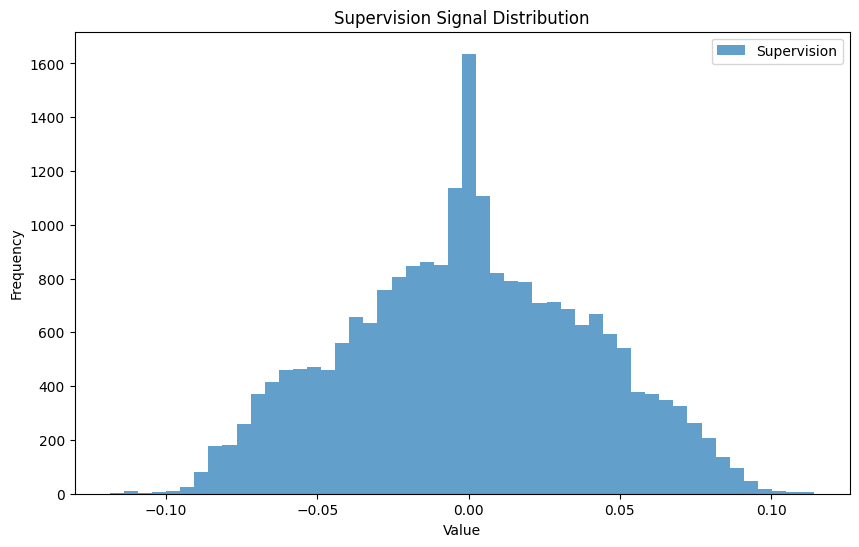

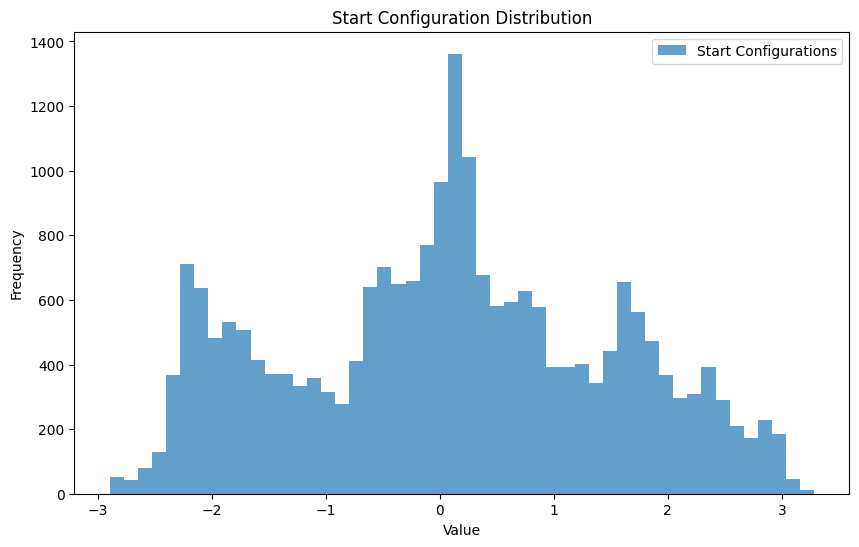

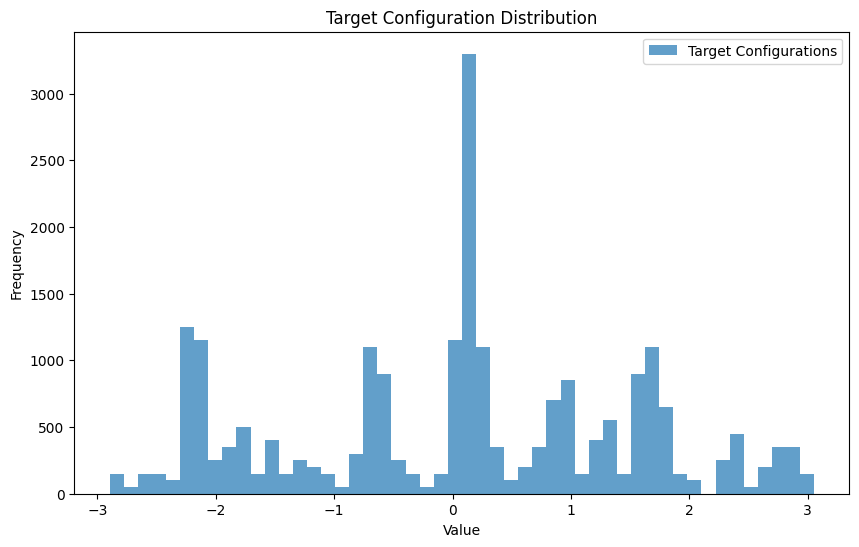

In [4]:
import torch
import numpy as np
# Check the number of batches in the train and validation loaders
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")


import matplotlib.pyplot as plt

# Analyze supervision signal distribution with a subset of 50 batches
supervision_differences = []
start_configurations = []
target_configurations = []

# Limit to 50 batches
for i, batch in enumerate(train_loader):
    if i >= 100:
        break
    supervision_differences.append(batch["supervision"].numpy())
    start_configurations.append(batch["configuration"].numpy())
    target_configurations.append(batch["target_configuration"].numpy())

# Convert to numpy arrays
supervision_differences = np.concatenate(supervision_differences, axis=0)
start_configurations = np.concatenate(start_configurations, axis=0)
target_configurations = np.concatenate(target_configurations, axis=0)

# Plot supervision signal distribution
plt.figure(figsize=(10, 6))
plt.hist(supervision_differences.flatten(), bins=50, alpha=0.7, label="Supervision")
plt.title("Supervision Signal Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot start configuration distribution
plt.figure(figsize=(10, 6))
plt.hist(start_configurations.flatten(), bins=50, alpha=0.7, label="Start Configurations")
plt.title("Start Configuration Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot target configuration distribution
plt.figure(figsize=(10, 6))
plt.hist(target_configurations.flatten(), bins=50, alpha=0.7, label="Target Configurations")
plt.title("Target Configuration Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Analyzing pretrain_data/curobo/train/train.hdf5...
HDF5 file structure:
  cuboid_centers (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_dims (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_quaternions (Dataset)
    Shape: (6000, 7, 4), Type: float32
  cylinder_centers (Dataset)
    Shape: (6000, 0, 3), Type: float32
  cylinder_heights (Dataset)
    Shape: (6000, 0, 1), Type: float32
  cylinder_quaternions (Dataset)
    Shape: (6000, 0, 4), Type: float32
  cylinder_radii (Dataset)
    Shape: (6000, 0, 1), Type: float32
  global_solutions (Dataset)
    Shape: (6000, 50, 7), Type: float32
  Found global_solutions at global_solutions with shape (6000, 50, 7)
Analyzing pretrain_data/ompl/train/train.hdf5...
HDF5 file structure:
  cuboid_centers (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_dims (Dataset)
    Shape: (6000, 7, 3), Type: float32
  cuboid_quaternions (Dataset)
    Shape: (6000, 7, 4), Type: float32
  cylinder_centers (Dataset)
    Shape: (6000, 

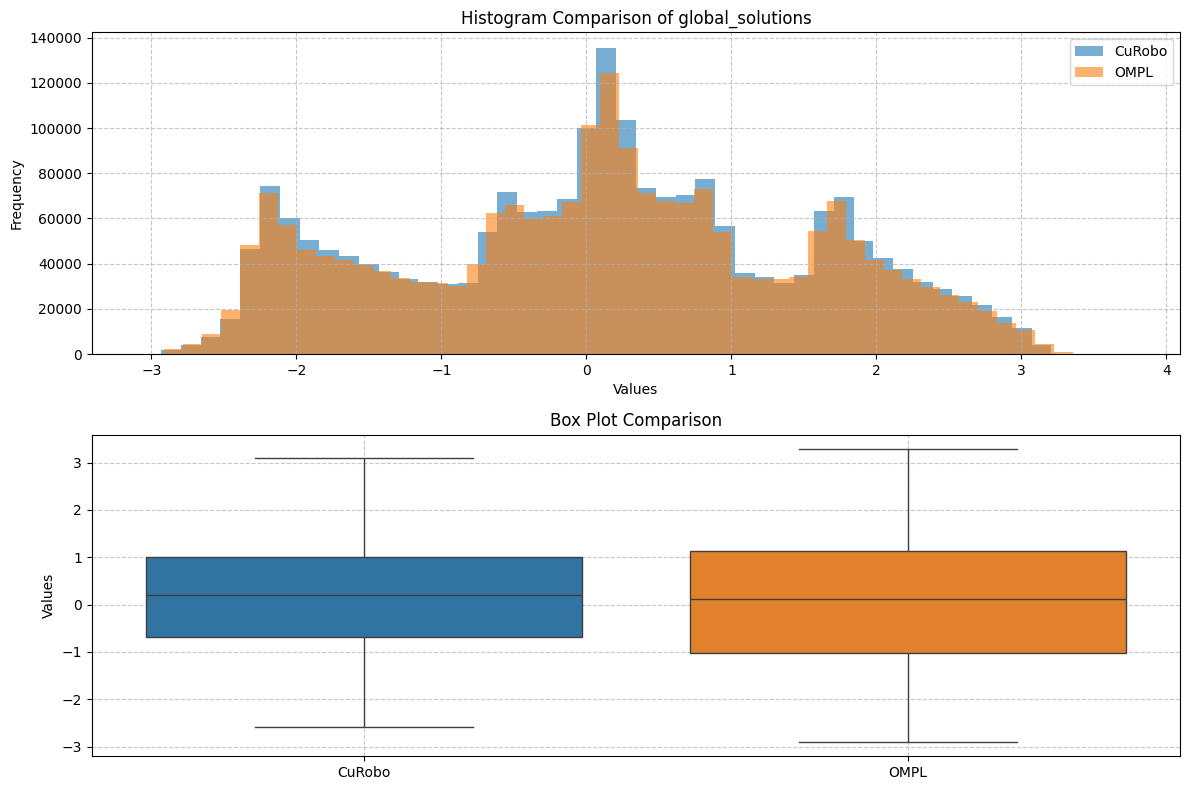

In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

def analyze_global_solutions(file_path):
    """Extract and analyze global_solutions from an HDF5 file"""
    print(f"Analyzing {file_path}...")
    solutions = []
    
    try:
        with h5py.File(file_path, 'r') as f:
            # Print the structure of the file to understand its contents
            print("HDF5 file structure:")
            def print_structure(name, obj):
                print(f"  {name} {'(Group)' if isinstance(obj, h5py.Group) else '(Dataset)'}")
                if isinstance(obj, h5py.Dataset):
                    print(f"    Shape: {obj.shape}, Type: {obj.dtype}")
            
            f.visititems(print_structure)
            
            # Try common paths where global_solutions might be stored
            possible_paths = ['global_solutions', 'data/global_solutions', 'solutions/global']
            
            for path in possible_paths:
                if path in f:
                    data = f[path][:]
                    solutions = data
                    print(f"  Found global_solutions at {path} with shape {data.shape}")
                    break
            
            # If not found in common paths, search for datasets with similar names
            if not len(solutions):
                for name, obj in f.items():
                    if isinstance(obj, h5py.Dataset) and 'solution' in name.lower():
                        data = obj[:]
                        solutions = data
                        print(f"  Found solutions at {name} with shape {data.shape}")
                        break
    
    except Exception as e:
        print(f"  Error processing file: {e}")
    
    return solutions

def compare_distributions():
    """Compare global_solutions distributions between CuRobo and OMPL"""
    # Define file paths
    curobo_file = "pretrain_data/curobo/train/train.hdf5"
    ompl_file = "pretrain_data/ompl/train/train.hdf5"
    
    # Check if files exist
    if not os.path.exists(curobo_file):
        print(f"File not found: {curobo_file}")
        return
    
    if not os.path.exists(ompl_file):
        print(f"File not found: {ompl_file}")
        return
    
    # Load and analyze data
    curobo_solutions = analyze_global_solutions(curobo_file)
    ompl_solutions = analyze_global_solutions(ompl_file)
    
    if len(curobo_solutions) == 0:
        print("No global_solutions found in CuRobo data")
        return
    
    if len(ompl_solutions) == 0:
        print("No global_solutions found in OMPL data")
        return
    
    # Flatten solutions for analysis if needed
    if isinstance(curobo_solutions, np.ndarray) and curobo_solutions.ndim > 1:
        curobo_values = curobo_solutions.flatten()
    else:
        curobo_values = curobo_solutions
        
    if isinstance(ompl_solutions, np.ndarray) and ompl_solutions.ndim > 1:
        ompl_values = ompl_solutions.flatten()
    else:
        ompl_values = ompl_solutions
    
    # Calculate statistics
    stats = {
        'Method': ['CuRobo', 'OMPL'],
        'Min': [np.min(curobo_values), np.min(ompl_values)],
        'Max': [np.max(curobo_values), np.max(ompl_values)],
        'Mean': [np.mean(curobo_values), np.mean(ompl_values)],
        'Median': [np.median(curobo_values), np.median(ompl_values)],
        'Std Dev': [np.std(curobo_values), np.std(ompl_values)],
        'Count': [len(curobo_values), len(ompl_values)]
    }
    
    # Display statistics
    stats_df = pd.DataFrame(stats).set_index('Method')
    print("\nStatistics Comparison:")
    print(stats_df)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Histogram comparison
    plt.subplot(2, 1, 1)
    plt.hist(curobo_values, bins=50, alpha=0.6, label='CuRobo')
    plt.hist(ompl_values, bins=50, alpha=0.6, label='OMPL')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram Comparison of global_solutions')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Box plot comparison
    plt.subplot(2, 1, 2)
    data = {
        'CuRobo': curobo_values[:min(len(curobo_values), 10000)],
        'OMPL': ompl_values[:min(len(ompl_values), 10000)]
    }
    sns.boxplot(data=pd.DataFrame(data))
    plt.title('Box Plot Comparison')
    plt.ylabel('Values')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('global_solutions_comparison.png')
    print("\nVisualization saved as 'global_solutions_comparison.png'")

if __name__ == "__main__":
    compare_distributions()

In [4]:
# Import necessary libraries
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from models.policynet import PolicyNet, TrainingPolicyNet
from data_loader import PointCloudInstanceDataset, DatasetType
from robofin.pointcloud.torch import FrankaSampler
import utils

In [8]:
# Configuration
MODEL_CHECKPOINT = "./checkpoints/tyztp0z2/epoch=46-step=437251.ckpt"  # Update with your checkpoint path
DATA_DIR = "./pretrain_data/curobo"  # Update with your data directory
TRAJECTORY_KEY = "global_solutions"
NUM_ROBOT_POINTS = 2048
NUM_OBSTACLE_POINTS = 4096
BATCH_SIZE = 4  # Small batch for visualization

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load model
model = TrainingPolicyNet.load_from_checkpoint(
    MODEL_CHECKPOINT,
    pc_latent_dim=2048,
    num_robot_points=NUM_ROBOT_POINTS,
    bc_loss_weight=1.0,
    collision_loss_weight=0.1
)
model.to(device)
model.eval()

# Initialize samplers if needed
if model.fk_sampler is None:
    model.fk_sampler = FrankaSampler(device, use_cache=True)

In [11]:
# Load data
dataset = PointCloudInstanceDataset(
    Path(DATA_DIR),
    TRAJECTORY_KEY,
    NUM_ROBOT_POINTS,
    NUM_OBSTACLE_POINTS,
    DatasetType.TRAIN,  # Using training data for testing
    random_scale=0.0    # No randomization for testing
)

# Create a small dataloader for testing
test_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Databases found: [PosixPath('pretrain_data/curobo/train/train.hdf5')]


In [12]:
# Get a batch of data
batch = next(iter(test_dataloader))

# Move data to device
for key in batch:
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].to(device)

In [23]:
# Run model prediction
with torch.no_grad():
    # Extract inputs
    xyz = batch["xyz"]
    q = batch["configuration"]
    target = batch["target_configuration"]
    supervision = batch["supervision"]
    
    # Forward pass
    model_output = model(xyz, q, target)
    prediction = torch.clamp(q + model_output, min=-1, max=1)
    
    # Calculate losses
    bc_loss = torch.nn.MSELoss()(prediction, supervision)
    
    # Calculate collision loss
    input_pc = model.fk_sampler.sample(
        utils.unnormalize_franka_joints(prediction), 
        model.num_robot_points
    )
    
    collision_loss = utils.collision_loss(
        input_pc,
        batch["cuboid_centers"],
        batch["cuboid_dims"],
        batch["cuboid_quats"],
        batch["cylinder_centers"],
        batch["cylinder_radii"],
        batch["cylinder_heights"],
        batch["cylinder_quats"],
    )
    
    # Total loss
    total_loss = model.bc_loss_weight * bc_loss + model.collision_loss_weight * collision_loss
    
    print(f"BC Loss: {bc_loss.item():.6f}")
    print(f"Collision Loss: {collision_loss.item():.6f}")
    print(f"Total Loss: {total_loss.item():.6f}")
    
    # Unnormalize predictions for better visualization/comparison
    q_unnorm = utils.unnormalize_franka_joints(q)
    pred_unnorm = utils.unnormalize_franka_joints(prediction)
    supervision_unnorm = utils.unnormalize_franka_joints(supervision)

BC Loss: 0.000061
Collision Loss: 0.000000
Total Loss: 0.000061


In [26]:
# Compare predictions with ground truth for the first item in batch
sample_idx = 1

print("\nSample comparison (joint angles in radians):")
print(f"\nInput configuration:")
print(q_unnorm[sample_idx].cpu().numpy())

print(f"\nModel prediction:")
print(pred_unnorm[sample_idx].cpu().numpy())

print(f"\nGround truth:")
print(supervision_unnorm[sample_idx].cpu().numpy())

# Calculate difference
diff = torch.abs(pred_unnorm[sample_idx] - supervision_unnorm[sample_idx])
print(f"\nAbsolute difference per joint:")
print(diff.cpu().numpy())
print(f"Mean absolute error: {diff.mean().item():.6f} radians")


Sample comparison (joint angles in radians):

Input configuration:
[ 1.5404027   0.09499347 -1.0789506  -1.6977282   2.0875795   2.7754998
 -1.0025941 ]

Model prediction:
[ 1.5267608   0.09366143 -1.0705204  -1.7033322   2.0666978   2.7689261
 -0.9954734 ]

Ground truth:
[ 1.4989331   0.06842685 -1.034916   -1.7141035   2.0182474   2.7393494
 -0.9365585 ]

Absolute difference per joint:
[0.02782774 0.02523458 0.03560436 0.01077127 0.04845047 0.02957678
 0.0589149 ]
Mean absolute error: 0.033769 radians


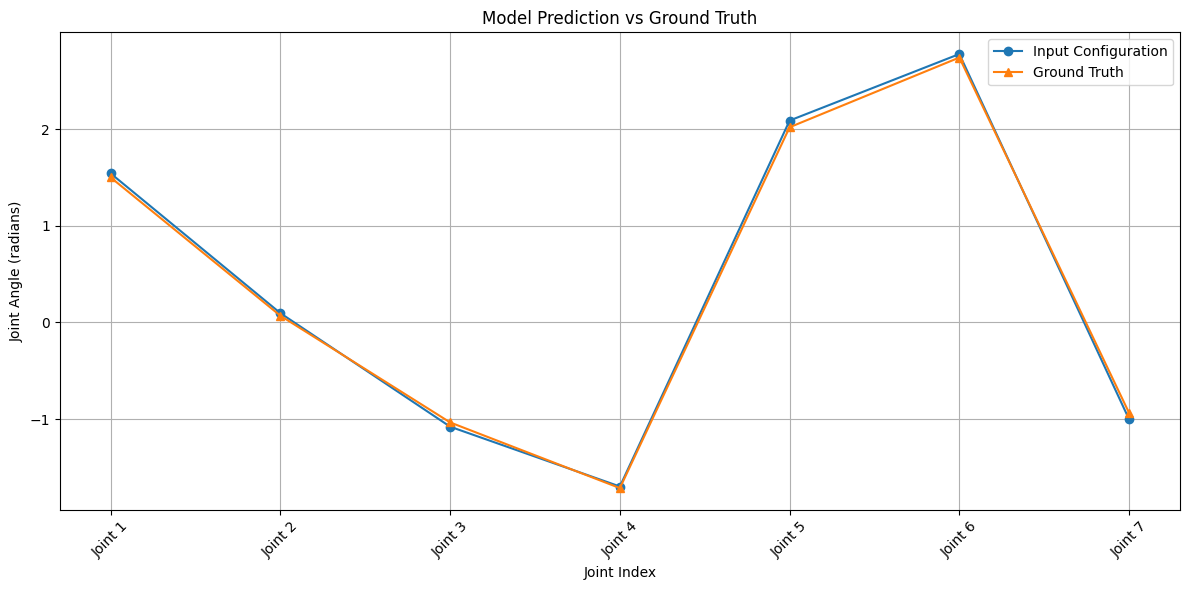

In [27]:
# Visualize prediction vs ground truth
joint_indices = np.arange(7)
joint_names = ["Joint 1", "Joint 2", "Joint 3", "Joint 4", "Joint 5", "Joint 6", "Joint 7"]

plt.figure(figsize=(12, 6))

# Plot input configuration
plt.plot(joint_indices, q_unnorm[sample_idx].cpu().numpy(), 'o-', label='Input Configuration')

# Plot prediction
# plt.plot(joint_indices, pred_unnorm[sample_idx].cpu().numpy(), 's-', label='Model Prediction')

# Plot ground truth
plt.plot(joint_indices, supervision_unnorm[sample_idx].cpu().numpy(), '^-', label='Ground Truth')

plt.xlabel('Joint Index')
plt.ylabel('Joint Angle (radians)')
plt.title('Model Prediction vs Ground Truth')
plt.xticks(joint_indices, joint_names, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()